## Data Mining 2024
### Final Project - Group 6

Beatriz Moreira, 54514 | Rute Patuleia, 51780 | João Lobato, 62611 | Tiago Assis, 62609

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from surprise import Dataset, Reader
from surprise import SVD, accuracy
from surprise.model_selection import train_test_split as train_test_split_s, GridSearchCV

In [2]:
activity_train = pd.read_csv("activity_train.csv", names=["protein", "molecule", "activity"])
activity_train["molecule"] = activity_train["molecule"].apply(lambda x: x.strip())
activity_test = pd.read_csv("activity_test_blanked.csv", names=["protein", "molecule", "activity"]).iloc[:,:2]
activity_test["molecule"] = activity_test["molecule"].apply(lambda x: x.strip())

In [3]:
mol_bits = pickle.load(open("mol_bits.pkl", "rb"))

mol_features = {}
for mol, feat in mol_bits.items():
    feat_vector = torch.zeros(2048, dtype=torch.float32)
    feat_vector[feat] = 1
    mol_features[mol] = feat_vector

In [4]:
combined_prot = set(np.concatenate([activity_train['protein'].unique(), activity_test['protein'].unique()]))
prot_mappings = {k: i for i, k in enumerate(combined_prot)}

In [5]:
combined_mol = set(np.concatenate([activity_train['molecule'].unique(), activity_test['molecule'].unique()]))
mol_mappings = {k: i for i, k in enumerate(combined_mol)}

## Neural Collaborative Filtering

##### https://doi.org/10.1145/3038912.3052569
He et al. 2017. Neural Collaborative Filtering. In Proceedings of the 26th International Conference on World Wide Web (WWW '17). International World Wide Web Conferences Steering Committee, Republic and Canton of Geneva, CHE, 173–182.

In [6]:
class NCF(nn.Module):
    def __init__(self, prot_vocab, mol_vocab, num_feats, embedding_dim, drop_prob=0.5):
        super().__init__()
        self.protein_embedding = nn.Embedding(prot_vocab, embedding_dim)
        self.molecule_embedding = nn.Embedding(mol_vocab, embedding_dim)
        
        self.fc1 = nn.Linear(2 * embedding_dim + num_feats, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 1)
        
        self.dropout = nn.Dropout(drop_prob)
        
        
    def forward(self, prot, mol, feat):
        prot_emb = self.protein_embedding(prot)
        mol_emb = self.molecule_embedding(mol)
        
        concat = torch.cat([prot_emb, mol_emb, feat], dim=-1)
        x = F.relu(self.fc1(concat))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x.squeeze()

In [7]:
class InteractionDataset(Dataset):
    def __init__(self, interaction_df, prot_mappings, mol_mappings, mol_feats, test=False, pred=False):
        self.prot_mappings = prot_mappings
        self.mol_mappings = mol_mappings
        self.mol_feats = mol_feats
        self.interaction_df = interaction_df
        self.test = test
        self.pred = pred

    def __getitem__(self, index):
        inputs = self.interaction_df.iloc[index,:]
        prot_idx = self.prot_mappings[inputs[0]]
        mol_idx = self.mol_mappings[inputs[1]]
        mol_feats = self.mol_feats[inputs[1]]
        if self.pred:
            return prot_idx, mol_idx, mol_feats
        return prot_idx, mol_idx, mol_feats, torch.tensor(inputs[2], dtype=torch.float32)
                                          
    def __len__(self):
        return len(self.interaction_df)

In [8]:
train_df, val_df = train_test_split(activity_train, test_size=0.2, random_state=13, shuffle=True, stratify=activity_train['protein'])

In [9]:
TRAIN = False
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 100
BATCH_SIZE = 128
EMBEDDING_DIM = 32
LR = 5e-5

num_prots = len(prot_mappings)
num_mols = len(mol_mappings)
num_features = 2048

train_dataset = InteractionDataset(train_df, prot_mappings, mol_mappings, mol_features)
val_dataset = InteractionDataset(val_df, prot_mappings, mol_mappings, mol_features)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = NCF(num_prots, num_mols, num_features, EMBEDDING_DIM).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)
loss_fn = nn.MSELoss()

In [10]:
def train(model, train_loader, loss_fn, optimizer):
    model.train()
    running_loss = 0.0
    for prot, mol, feat, act in train_loader:
        prot = prot.to(DEVICE)
        mol = mol.to(DEVICE)
        feat = feat.to(DEVICE)
        act = act.to(DEVICE)
        
        optimizer.zero_grad()
        preds = model(prot, mol, feat)
        loss = loss_fn(preds, act)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    return running_loss / len(train_loader)

def evaluate(model, val_loader, loss_fn):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for prot, mol, feat, act in val_loader:
            prot = prot.to(DEVICE)
            mol = mol.to(DEVICE)
            feat = feat.to(DEVICE)
            act = act.to(DEVICE)
            
            preds = model(prot, mol, feat)
            loss = loss_fn(preds, act)
            
            running_loss += loss.item()
    
    return running_loss / len(val_loader)

In [11]:
def trainer(model, train_dataloader, val_dataloader, loss_fn, optimizer):
    train_losses = []
    val_losses = []
    for epoch in range(EPOCHS):
        train_loss = train(model, train_dataloader, loss_fn, optimizer)
        train_losses.append(train_loss)
        val_loss = evaluate(model, val_dataloader, loss_fn)
        val_losses.append(val_loss)
        scheduler.step()
        if epoch % 10 == 9:
            torch.save(model.state_dict(), f"model-epoch{epoch+1}.pth")
            print(f'Epoch {epoch+1}/{EPOCHS}, Train RMSE: {np.sqrt(train_loss):.4f}, Val RMSE: {np.sqrt(val_loss):.4f}')
    return train_losses, val_losses

In [ ]:
if TRAIN:
    train_losses, val_losses = trainer(model, train_dataloader, val_dataloader, loss_fn, optimizer)

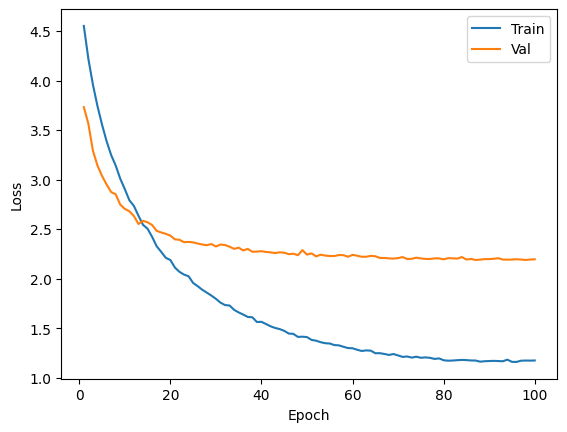

In [187]:
if TRAIN:
    plt.plot(range(1,EPOCHS+1), train_losses, label="Train")
    plt.plot(range(1,EPOCHS+1), val_losses, label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig("train_val.png")
    plt.show()

In [58]:
summary(model)

Layer (type:depth-idx)                   Param #
NCF                                      --
├─Embedding: 1-1                         4,608
├─Embedding: 1-2                         2,363,680
├─Linear: 1-3                            2,163,712
├─Linear: 1-4                            262,400
├─Linear: 1-5                            16,448
├─Linear: 1-6                            65
├─Dropout: 1-7                           --
Total params: 4,810,913
Trainable params: 4,810,913
Non-trainable params: 0

#### Evaluation NCF

In [21]:
MODEL_PATH = "model-epoch100.pth"
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [23]:
model.eval()
running_loss = 0.0
absolute_error = 0.0

with torch.no_grad():
    for prot, mol, feat, act in val_dataloader:
        prot = prot.to(DEVICE)
        mol = mol.to(DEVICE)
        feat = feat.to(DEVICE)
        act = act.to(DEVICE)
            
        preds = model(prot, mol, feat)
        loss = loss_fn(preds, act)

        absolute_error += mean_absolute_error(act.cpu().detach(), preds.cpu().detach())
        running_loss += np.sqrt(loss.item())

print(f'RMSE: {(running_loss / len(val_dataloader)):.4f}')
print(f'MAE: {(absolute_error / len(val_dataloader)):.4f}')

RMSE: 2.5061
MAE: 1.9685


#### Prediction NCF

In [189]:
pred_dataset = InteractionDataset(activity_test, prot_mappings, mol_mappings, mol_features, pred=True)
pred_dataloader = DataLoader(dataset=pred_dataset)

In [190]:
activity_preds_mlp = []
model.eval()
with torch.no_grad():
    for prot_id, mol_id, feat in pred_dataloader:
        prot_id = prot_id.to(DEVICE)
        mol_id = mol_id.to(DEVICE)
        feat = feat.to(DEVICE)
            
        pred = model(prot_id, mol_id, feat)
        pred = pred.cpu().detach().item()
        
        activity_preds_mlp.append(np.clip(pred, 1, 10))

In [191]:
preds_mlp = pd.concat([activity_test, pd.Series(activity_preds_mlp, name="activity")], axis=1)
preds_mlp.head(10)

,protein,molecule,activity
0,O14842,CHEMBL2022258,4.991796
1,O14842,CHEMBL2047161,6.653746
2,O14842,CHEMBL2047163,5.109513
3,O14842,CHEMBL2047168,6.303686
4,O14842,CHEMBL2047169,5.880341
5,O14842,CHEMBL2048621,6.012907
6,O14842,CHEMBL2048623,6.554904
7,O14842,CHEMBL207881,2.869274
8,O14842,CHEMBL4067052,2.810349
9,O14842,CHEMBL4069191,5.328992


---

## SVD Matrix Factorization

In [192]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(activity_train[['protein', 'molecule', 'activity']], reader)
gridsearch = False

In [ ]:
if gridsearch:
    param_grid = {
        'n_factors': [10, 15, 20, 25, 30, 35],
        'n_epochs': [10, 15, 20, 25, 30],
        'lr_all': [0.05, 0.025, 0.01, 0.005, 0.0025, 0.001],
        'reg_all': [0.2, 0.15, 0.1, 0.05],
        'random_state': [13]
    }

    grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
    grid_search.fit(data)

    best_params = grid_search.best_params['rmse']
    print(f'Best RMSE: {grid_search.best_score["rmse"]}')
    print(f'Best parameters: {best_params}')

In [193]:
best_params = {'n_factors': 25, 'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.1, 'random_state': 13}

#### Evaluation SVD MF

In [194]:
train = data.build_full_trainset()
best_model = SVD(**best_params)

train, val = train_test_split_s(data, test_size=0.2, random_state=13, shuffle=True)
best_model.fit(train)
preds = best_model.test(val)
rmse = accuracy.rmse(preds)
mae = accuracy.mae(preds)

RMSE: 2.4225
MAE:  1.9898


#### Prediction SVD MF

In [195]:
preds_svd_mf = activity_test.copy()
preds_svd_mf['activity'] = 0

In [196]:
test_data = Dataset.load_from_df(preds_svd_mf[['protein', 'molecule', 'activity']], reader)
test = test_data.build_full_trainset().build_testset()

In [197]:
preds = best_model.test(test)
preds_list = [np.clip(pred.est, 1, 10) for pred in preds]
preds_svd_mf['activity'] = preds_list

In [198]:
preds_svd_mf.head(10)

,protein,molecule,activity
0,O14842,CHEMBL2022258,5.252942
1,O14842,CHEMBL2047161,5.252942
2,O14842,CHEMBL2047163,5.252942
3,O14842,CHEMBL2047168,5.252942
4,O14842,CHEMBL2047169,5.252942
5,O14842,CHEMBL2048621,5.252942
6,O14842,CHEMBL2048623,5.252942
7,O14842,CHEMBL207881,5.678666
8,O14842,CHEMBL4067052,5.252942
9,O14842,CHEMBL4069191,5.252942


---

## User-User Collaborative Filtering

In [199]:
def RowCenterMatrix(M):
    row_means = np.expand_dims(np.nanmean(M, axis=1), axis=1)
    MC = M - row_means
    MC[np.isnan(MC)] = 0
    return MC


def CosSim_Matrix(M):
    norms = np.sqrt(np.sum(np.square(M), axis=1))
    norms[norms < 1e-6] = 1e-6 #this will solve rows or cols without variance
    norms_M = np.outer(norms, norms)
    return np.dot(M, M.T) / norms_M


def make_GBAMatrix(M):
    global_mean = np.nanmean(M)
    row_means = np.nanmean(M, axis=1)
    prot_dif = row_means - global_mean
    col_means = np.nanmean(M, axis=0)
    mol_dif = col_means - global_mean
    return global_mean, prot_dif, mol_dif


def estimate_score(mat, SM, gba, nn, row, col, verbose=False):
    N, M = mat.shape
    sims = list(zip(SM[row], range(N)))
    sims.sort()
    sims.reverse()
    
    cnt, S, Ssims = 0, 0, 0
    if verbose: print("row: %d - col: %d" % (row,col))
    for  sim, idx in sims[1:]:
        if not np.isnan(mat[idx, col]) and sim > 0:
            r = gba[0] + gba[1][idx] + gba[2][col]
            S += sim * (mat[idx, col] - r)
            Ssims += sim
            cnt += 1
            if verbose: print("\tItem:%4d    Score:%4.1f (Sim: %6.3f)" %(idx, mat[idx, col], sim))
        if cnt >= nn: break
    
    r = gba[0] + (gba[1][row] if not np.isnan(gba[1][row]) else 0) + (gba[2][col] if not np.isnan(gba[2][col]) else 0)

    if Ssims <= 0:
        if verbose: print("\tNo similars: outputing the Global Baseline Average")
        if verbose: print("\tScore: %7.4f" % r)
        return r
    if verbose: print("\tScore: %7.4f" % (r + S / Ssims))

    return r + S / Ssims

#### Evaluation U-U CF

In [200]:
cols = activity_train['molecule'].map(mol_mappings).values.copy()
rows = activity_train['protein'].map(prot_mappings).values.copy()
data_train = activity_train['activity'].values.copy()
data_val = data_train.copy()
data_val[val_df.index] = 0

uu_matrix = np.empty((len(prot_mappings), len(mol_mappings)))
uu_matrix[:] = np.nan
val_uu_matrix = uu_matrix.copy()
uu_matrix[rows, cols] = data_train
val_uu_matrix[rows, cols] = data_val
val_uu_matrix[val_uu_matrix == 0] = np.nan

In [201]:
gba = make_GBAMatrix(val_uu_matrix)
gba[0], gba[1].shape, gba[2].shape

(4.705318325841868, (144,), (73865,))

In [202]:
val_uu_c_matrix = RowCenterMatrix(val_uu_matrix)
val_uu_sim_matrix = CosSim_Matrix(val_uu_c_matrix)

In [203]:
validation = []
for i, (prot, mol, _) in val_df.iterrows():
    prot_idx = prot_mappings[prot]
    mol_idx = mol_mappings[mol]
    pred = estimate_score(val_uu_matrix, val_uu_sim_matrix, gba, 10, prot_idx, mol_idx)
    validation.append(np.clip(pred, 1, 10))

In [204]:
val_df["activity (pred)"] = validation

In [205]:
rmse = root_mean_squared_error(val_df['activity'], val_df['activity (pred)'])
mae = mean_absolute_error(val_df['activity'], val_df['activity (pred)'])
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 2.6415
MAE: 2.0389


#### Prediction U-U CF

In [206]:
gba = make_GBAMatrix(uu_matrix)
print(gba[0], gba[1].shape, gba[2].shape)

uu_c_matrix = RowCenterMatrix(uu_matrix)
uu_sim_matrix = CosSim_Matrix(uu_c_matrix)

4.708792949724046 (144,) (73865,)


In [207]:
activity_preds_cf = []
for i, (prot, mol) in activity_test.iterrows():
    prot_idx = prot_mappings[prot]
    mol_idx = mol_mappings[mol]
    pred = estimate_score(uu_matrix, uu_sim_matrix, gba, 10, prot_idx, mol_idx)
    activity_preds_cf.append(np.clip(pred, 1, 10))

In [208]:
preds_uu_cf = pd.concat([activity_test, pd.Series(activity_preds_cf, name="activity")], axis=1)
preds_uu_cf.head(10)

,protein,molecule,activity
0,O14842,CHEMBL2022258,5.370968
1,O14842,CHEMBL2047161,5.370968
2,O14842,CHEMBL2047163,5.370968
3,O14842,CHEMBL2047168,5.370968
4,O14842,CHEMBL2047169,5.370968
5,O14842,CHEMBL2048621,5.370968
6,O14842,CHEMBL2048623,5.370968
7,O14842,CHEMBL207881,3.328841
8,O14842,CHEMBL4067052,5.370968
9,O14842,CHEMBL4069191,5.370968


---

## Ensemble

In [209]:
preds_ensemble = activity_test.copy()
preds_ensemble['activity'] = (preds_uu_cf['activity'] + preds_mlp['activity'] + preds_svd_mf['activity']) / 3

In [210]:
preds_ensemble.head(10)

,protein,molecule,activity
0,O14842,CHEMBL2022258,5.205235
1,O14842,CHEMBL2047161,5.759218
2,O14842,CHEMBL2047163,5.244474
3,O14842,CHEMBL2047168,5.642532
4,O14842,CHEMBL2047169,5.501417
5,O14842,CHEMBL2048621,5.545606
6,O14842,CHEMBL2048623,5.726271
7,O14842,CHEMBL207881,3.958927
8,O14842,CHEMBL4067052,4.478086
9,O14842,CHEMBL4069191,5.317634


#### Saving Predictions CSV

In [211]:
preds_ensemble.to_csv("predicted_values.txt", index=False, header=False)